# ライブラリ

In [52]:
# !pip install librosa
# !pip install tqdm
# !pip install pycm


In [53]:
#ライブラリのインポート 
import librosa
import os
import matplotlib.pyplot as plt
import numpy as np
import IPython.display
import pandas as pd
import statistics as sta
import torch
import torch.nn as nn
import torch.nn.functional as F

print(librosa.__version__)
print(torch.__version__)

#ライブラリ
from sklearn import svm
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import LabelEncoder

# t-SNE 特徴量空間上での可視化
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

from numpy.random import default_rng
rng = default_rng(0)

from sklearn.metrics import confusion_matrix
import seaborn as sns; sns.set() # グラフ描画用
from sklearn.metrics import classification_report

import pandas as pd

from pycm import ConfusionMatrix

0.10.2.post1
2.2.2


# データセットの作成

In [55]:
sr = 44100 #サンプリング周波数

## 試行ごとに分割

In [54]:


# #ファイルパスの指定
# origin_data = "data/origin_data/origindata_20240619"

# #学習用データの読み込み
# audio_dir = origin_data
# subFolders = [f for f in os.listdir(audio_dir) if os.path.isdir(os.path.join(audio_dir, f))]
# subFolders = sorted(subFolders) #昇順に並び替え

# #ファイル読み込み
# # originDatasに音声データを格納していく
# originDatas = []
# for subFolder in subFolders:
#     filePath = audio_dir+"/"+subFolder+"/"+subFolder+".WAV"
#     originData, sr = librosa.load(filePath, sr = sr)
#     originDatas.append(originData)
#     print(subFolder)
# #1データから30試行をトリミングを22パターン分行い，soundDataset_new_newに格納する
# # soundDataset_new_newの構造：[パターン(10)][試行(50)][サンプリングデータ(66150)]

# flag_amp = 0.1 #各試行の合図を検知する基準振幅
# trimSkip = int(sr*0.4)
# trimTime = int(sr*1.5)#1試行あたりのデータ長
# dataNum = 50
# trial = 0
# soundDataset_new =([])

# while trial <len(originDatas):
#     index = 0
#     trimDatas = ([]) #1データ(30試行)分のトリミングデータのリストを初期化
#     originData = np.array(originDatas[trial])
#     while index <len(originData):
#         if originData[index] >= flag_amp:
#             trimData = np.array(originData[index+trimSkip:index+trimTime+trimSkip]) #trim_dataにそのindexからindex+trimTimeのデータを格納する
#             trimDatas = np.append(trimDatas ,trimData, axis=0)  #trimDatasに追加する
#             index += trimTime
#         else:
#             index +=1
#         if len(trimDatas) >=dataNum*trimTime:
#             break
#     soundDataset_new = np.append(soundDataset_new,np.array(trimDatas),axis=0)
#     trial += 1

# soundDataset_new = soundDataset_new.reshape(len(originDatas),dataNum,trimTime)

# print(soundDataset_new.shape)

# import pickle
# f = open('soundDataset_20240619.pickle','wb')
# pickle.dump(soundDataset_new,f)

## ラベルを含んだデータセット化

In [56]:
import pickle
f = open('soundDataset_20240619.pickle','rb')
soundDataset_new = pickle.load(f)

patterns = soundDataset_new.shape[0] #物体の種類
trials = soundDataset_new.shape[1] #試行数
len_data = soundDataset_new.shape[2] #1試行の長さ,サンプル数
num_data = patterns*trials #全試行数

print(patterns,trials,len_data,num_data)

21 50 66150 1050


### ラベルのリスト

In [57]:
#object層
objLabel = [
    "y-shirt", 
    "jeans", 
    "sweatshirt", 

    "blanket", 
    "bedquilt", 
    "pillow", 
       
    "mousepad", 
    "chair", 
    "sofa", 
    
    "thick-Book", 
    "thin-Book", 
    "cardboard", 

    "metal-desk", 
    "laptop", 
    "alumi-rack", 
    
    "wood-desk", 
    "wood-shelf", 
    "floor", 
    
    "pla-Case", 
    "pla-Container", 
    "pla-Shelf"
]
objNum= []

#material層
matLabel = [
    "clothing",
    "bedding", 
    "memory-foam", 
    "paper", 
    "metal", 
    "wood", 
    "plastic"
]

matNum = [0,1,2,3,4,5,6]

#soft-hard層
shLabel = [
    "soft",
    "hard",
]

shNum = [0,1]





### wavファイルの作成

In [58]:
# import soundfile as sf

# # wavファイルへの変換
# def MakeTrimData(target_num,trial):
#     # 既存のサンプル数66150の配列
#     audio_data = soundDataset_new[target_num][trial]

#     # WAVファイルに書き込む
#     output_file = 'data/trim_data/trim-data_'+str(target_num)+'_'+str(trial)+'.wav'
#     sample_rate = 44100  # サンプルレート（例: 44100 Hz）
#     sf.write(output_file, audio_data, sample_rate)

#     print(f"WAVファイル '{output_file}' に書き込みました。")

# # wavファイルへの変換実行
# for target_num in range(len(soundDataset_new)):
#     for trial in range(len(soundDataset_new[0])):
#         MakeTrimData(target_num,trial)

### データフレーム化・CSVに書き出し

In [59]:
# num_feature次元のMFCCのデータフレームを作成

# ファイル名の生成と追加
filenames = []
for target_num in range(21):
    for trial in range(50):
        filenames.append(f'trim-data_{target_num}_{trial}.wav')

Dataset = pd.DataFrame()

Dataset['filename'] = filenames
Dataset['objectNum'] = [i // soundDataset_new.shape[1] for i in range(1050)]
Dataset['matNum'] = np.repeat(matNum, 150)[:1050]
Dataset['shNum'] = np.array([0]*450 + [1]*600)

# データセットに'objLabel'の列を追加
Dataset['object'] = np.repeat(objLabel, 50)[:1050]

# # データセットに'matLabel'の列を追加
Dataset['mat'] = np.repeat(matLabel, 150)[:1050]

# # データセットに'SHLabel'の列を追加
Dataset['sh'] = np.array(['soft']*450 + ['hard']*600)


# データフレームをCSVファイルに保存
# csv_path = 'data/dataset_vib.csv'
# Dataset.to_csv(csv_path, index=True)

# Display the DataFrame
pd.set_option('display.max_rows', 100)

Dataset

,filename,objectNum,matNum,shNum,object,mat,sh
0,trim-data_0_0.wav,0,0,0,y-shirt,clothing,soft
1,trim-data_0_1.wav,0,0,0,y-shirt,clothing,soft
2,trim-data_0_2.wav,0,0,0,y-shirt,clothing,soft
3,trim-data_0_3.wav,0,0,0,y-shirt,clothing,soft
4,trim-data_0_4.wav,0,0,0,y-shirt,clothing,soft
...,...,...,...,...,...,...,...
1045,trim-data_20_45.wav,20,6,1,pla-Shelf,plastic,hard
1046,trim-data_20_46.wav,20,6,1,pla-Shelf,plastic,hard
1047,trim-data_20_47.wav,20,6,1,pla-Shelf,plastic,hard
1048,trim-data_20_48.wav,20,6,1,pla-Shelf,plastic,hard


### MFCCのデータセット作成

In [60]:
# 特徴量の次元数
num_feature = 40

# 空のmfccSetを初期化
mfccSet = np.empty((0, num_feature))

# ループを使用してMFCCを抽出してmfccSetに追加
for pattern in range(patterns):
    for trial in range(trials):
        # MFCCを計算
        mfccs = librosa.feature.mfcc(y=soundDataset_new[pattern][trial], sr=sr)
        
        # MFCCの各次元の平均を算出
        mean = mfccs.mean(axis=1)
        
        # MFCCの各次元の標準偏差を算出
        std = np.std(mfccs, axis=1)
        
        # mean, max_val, min_val, std をまとめた配列を作成
        combined_stats = np.concatenate([mean,  std])

        # mfccSetに追加
        mfccSet = np.append(mfccSet, [combined_stats], axis=0)

# 形状を確認
print(mfccSet.shape)

(1050, 40)


In [61]:
# ファイル名の生成と追加

Dataset_mfcc = pd.DataFrame(data=mfccSet)

Dataset_mfcc['objNum'] = [i // soundDataset_new.shape[1] for i in range(1050)]
Dataset_mfcc['matNum'] = np.repeat(matNum, 150)[:1050]
Dataset_mfcc['shNum'] = np.array([0]*450 + [1]*600)

# データセットに'objLabel'の列を追加
Dataset_mfcc['obj'] = np.repeat(objLabel, 50)[:1050]

# # データセットに'matLabel'の列を追加
Dataset_mfcc['mat'] = np.repeat(matLabel, 150)[:1050]

# # データセットに'SHLabel'の列を追加
Dataset_mfcc['sh'] = np.array(['soft']*450 + ['hard']*600)


# データフレームをCSVファイルに保存
# csv_path = 'data/meta_data/dataset_vib_mfcc.csv'
# Dataset_mfcc.to_csv(csv_path, index=True)

# Display the DataFrame
pd.set_option('display.max_rows',100)

Dataset_mfcc

,0,1,2,3,4,5,6,7,8,9,...,36,37,38,39,objNum,matNum,shNum,obj,mat,sh
0,-478.001703,63.457280,36.144773,26.225528,16.727231,14.407245,13.285984,9.590793,9.811856,5.082892,...,3.645248,3.399917,3.804335,3.734329,0,0,0,y-shirt,clothing,soft
1,-476.196495,67.811489,42.117584,28.188400,15.583791,13.266734,12.080886,8.774526,8.174143,4.179097,...,3.640349,3.322606,3.285746,3.343535,0,0,0,y-shirt,clothing,soft
2,-477.773147,65.936731,41.942033,28.753131,17.348440,16.986556,15.279845,11.019433,9.088018,5.031381,...,3.156580,3.407280,3.517655,3.547526,0,0,0,y-shirt,clothing,soft
3,-482.200915,63.764375,39.955530,26.105635,15.753873,13.904783,13.131842,9.218075,7.482949,4.541441,...,3.725960,3.272637,3.092343,3.604951,0,0,0,y-shirt,clothing,soft
4,-479.097029,65.641729,40.932618,27.617450,16.556075,14.817480,14.321870,10.350258,8.893235,4.703604,...,3.328177,3.571923,3.805326,4.301650,0,0,0,y-shirt,clothing,soft
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,-462.453427,78.334440,45.349090,29.702114,15.009005,12.011045,13.299042,9.038196,6.716250,1.844909,...,3.297809,3.660277,3.493659,4.016997,20,6,1,pla-Shelf,plastic,hard
1046,-462.308041,79.059942,46.864514,30.124729,14.844601,12.301888,14.513218,10.563808,7.084634,1.905388,...,3.441372,3.365149,3.482850,4.577083,20,6,1,pla-Shelf,plastic,hard
1047,-461.417660,80.208434,46.588974,29.178092,14.371811,11.147610,12.965775,10.084192,7.170428,2.227163,...,3.539720,3.766647,4.083665,4.772348,20,6,1,pla-Shelf,plastic,hard
1048,-464.390102,76.848395,45.564795,31.331828,17.138878,14.709765,15.806167,10.320537,7.870815,3.794003,...,3.418645,3.032147,3.479765,4.267387,20,6,1,pla-Shelf,plastic,hard


### メルスペクトログラムのデータセット

In [62]:
# パターンごとにスペクロログラムの保存
Dataset_melspec = []
trial_num = 50
for patern in range (len(soundDataset_new)):
    for trial in range(trial_num):
        trimData = soundDataset_new[patern,trial]
        spectrogram = librosa.feature.melspectrogram(y=trimData, sr=sr)# スペクトログラムを計算
        spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)    
        Dataset_melspec.append(spectrogram_db)

Dataset_melspec = np.array(Dataset_melspec)
print(Dataset_melspec.shape)
print(type(Dataset_melspec))

(1050, 128, 130)
<class 'numpy.ndarray'>


# 評価

## t-SNEで特徴量空間の可視化

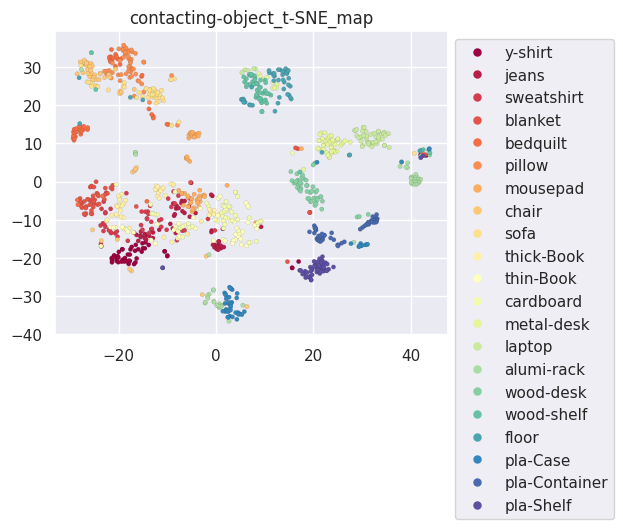

In [63]:


tsne = TSNE(
    n_components=2,
    perplexity=30.0,
    random_state=(0)
)
X_tsne = tsne.fit_transform(Dataset_mfcc.iloc[:,1:num_feature])

# プロット
title = "contacting-object_t-SNE_map"
plt.title(title)

scatter=plt.scatter(
            X_tsne[:, 0], 
            X_tsne[:, 1], 
            c=Dataset_mfcc['objNum'], 
            cmap='Spectral',
            edgecolor='black',
            linewidths=0.05,
            s=10 
        )  
# 凡例を追加
plt.legend(handles=scatter.legend_elements(num=21)[0],labels=objLabel,bbox_to_anchor=(1, 1), loc='upper left')

plt.tight_layout()

# plt.savefig("data/output_data/"+title+".pdf")

## SVMでの評価

In [64]:
def Eval_svm(subject,trainDataset,labelDataset,target,save):
    #機械学習アルゴリズムの選択
    model = svm.SVC(kernel="linear",C =0.01,random_state = 0) 

    #10分割交差検証
    folds = 10 #分割数
    stratifiedkfold = StratifiedKFold(n_splits=folds, shuffle=True, random_state=0) #10分割交差検証のパラメータ定義

    pred = cross_val_predict(model, trainDataset,labelDataset, cv=stratifiedkfold)
    
    #classification_reportの作成
    report = classification_report(labelDataset, pred,digits=3,target_names=target)
    print(report)
    
    #混同行列の作成
    cm = confusion_matrix(y_true=labelDataset,y_pred=pred)
    p = sns.heatmap(cm, square=True, cbar=True, annot=True,cmap='Blues',fmt="d",
                    label=target,
                    xticklabels=target,
                    yticklabels=target)
    title = "confusion_matrix_"+subject
    plt.title(title)
    plt.xlabel('predict')
    plt.ylabel('actual')

    #保存設定
    if save == True:
        plt.savefig('data/output_data/'+title+'.pdf', bbox_inches='tight')
        with open('data/output_data/eval_report_'+subject+'.pdf','w') as f:
            print(report)


### object層

               precision    recall  f1-score   support

      y-shirt      0.896     0.860     0.878        50
        jeans      0.833     0.800     0.816        50
   sweatshirt      0.868     0.920     0.893        50
      blanket      0.644     0.760     0.697        50
     bedquilt      0.848     0.780     0.812        50
       pillow      0.809     0.760     0.784        50
     mousepad      0.712     0.740     0.725        50
        chair      1.000     0.960     0.980        50
         sofa      0.933     0.840     0.884        50
   thick-Book      0.741     0.860     0.796        50
    thin-Book      0.792     0.840     0.816        50
    cardboard      0.887     0.940     0.913        50
   metal-desk      0.980     0.980     0.980        50
       laptop      0.961     0.980     0.970        50
   alumi-rack      0.860     0.860     0.860        50
    wood-desk      0.654     0.680     0.667        50
   wood-shelf      0.933     0.840     0.884        50
        f

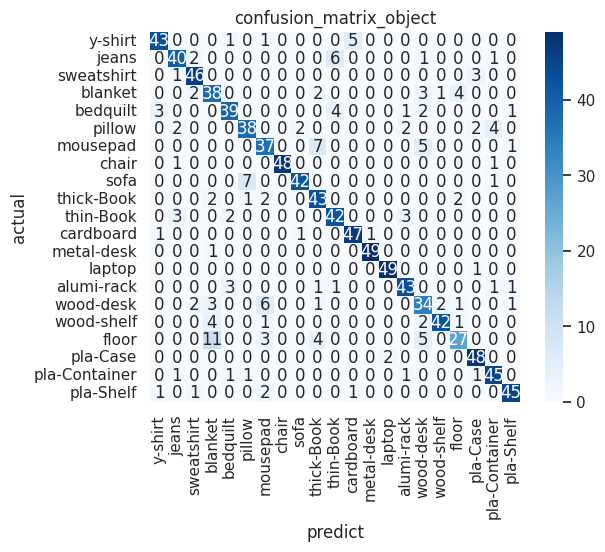

In [65]:
Eval_svm(
    "object",
    Dataset_mfcc.iloc[:,1:num_feature],
    Dataset_mfcc.obj,
    objLabel,
    False
    )

### material層

              precision    recall  f1-score   support

    clothing      0.808     0.840     0.824       150
     bedding      0.787     0.887     0.834       150
 memory-foam      0.784     0.653     0.713       150
       paper      0.943     0.880     0.910       150
       metal      0.800     0.853     0.826       150
        wood      0.929     0.960     0.944       150
     plastic      0.910     0.880     0.895       150

    accuracy                          0.850      1050
   macro avg      0.852     0.850     0.849      1050
weighted avg      0.852     0.850     0.849      1050



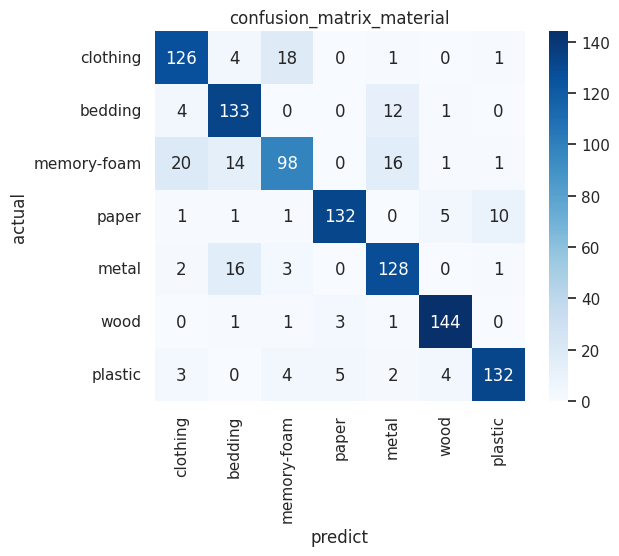

In [66]:
Eval_svm(
    "material",
    Dataset_mfcc.iloc[:,1:num_feature],
    Dataset_mfcc.mat,
    matLabel,
    False
    )

### soft-hard層

              precision    recall  f1-score   support

        soft      0.895     0.897     0.896       600
        hard      0.862     0.860     0.861       450

    accuracy                          0.881      1050
   macro avg      0.879     0.878     0.878      1050
weighted avg      0.881     0.881     0.881      1050



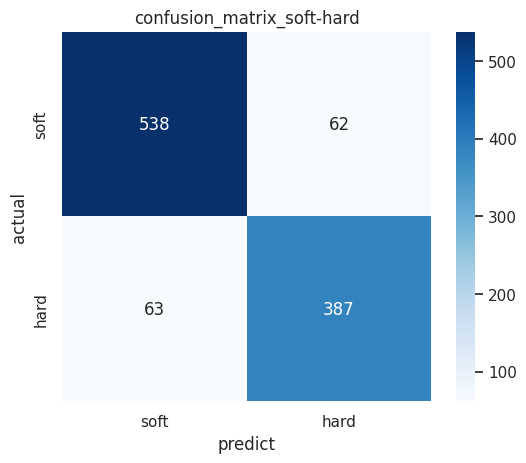

In [67]:
Eval_svm(
    "soft-hard",
    Dataset_mfcc.iloc[:,1:num_feature],
    Dataset_mfcc.sh,
    shLabel,
    False
    )

### torchデータセットの作成

In [68]:
# パターンごとにスペクロログラムの保存
df = []
trial_num = 50
for patern in range (len(soundDataset_new)):
    for trial in range(trial_num):
        trimData = soundDataset_new[patern,trial]
        spectrogram = librosa.feature.melspectrogram(y=trimData, sr=sr)# スペクトログラムを計算
        spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)    
        df.append(spectrogram_db)

df = np.array(df)
print(df.shape)
print(type(df))

(1050, 128, 130)
<class 'numpy.ndarray'>


In [69]:
print(df.shape) #(1050,128,130)


(1050, 128, 130)


### soft-hard 1

In [70]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [71]:

# ラベルの指定
t_df = Dataset.shNum

# テンソル形式に変換
df_tenosor = torch.tensor(df, dtype=torch.float32)
df_tenosor = torch.unsqueeze(df_tenosor, 1)
label_tensor = torch.tensor(t_df, dtype=torch.int64)
print(df_tenosor.size())

# x と t を組み合わせて TensorDataset を作成
dataset = torch.utils.data.TensorDataset(df_tenosor, label_tensor)

# 各データセットのサンプル数を決定
# train : val: test = 50%　: 25% : 25%
n_train = int(len(dataset) * 0.5)
n_val = int(len(dataset) * 0.25)
n_test = len(dataset) - n_train - n_val
     
# それぞれのサンプル数を確認
print(n_train, n_val, n_test)

# ランダムに分割を行うため、シードを固定して再現性を確保
torch.manual_seed(0)

# データセットの分割
train, val, test = torch.utils.data.random_split(dataset, [n_train, n_val, n_test])

# バッチサイズ
batch_size = 25

      
# shuffle はデフォルトで False のため、学習データのみ True に指定
train_loader = torch.utils.data.DataLoader(train, batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val, batch_size)
test_loader = torch.utils.data.DataLoader(test, batch_size)

print(train_loader)

for batch in train_loader:
    print(batch)

torch.Size([1050, 1, 128, 130])
525 262 263
[tensor([[[[-15.7372, -12.7907, -12.2806,  ..., -16.2258, -12.1957, -14.6959],
          [-15.7418, -11.8346, -11.9373,  ..., -12.7932, -11.7111, -12.4843],
          [-22.5785, -21.3953, -21.5793,  ..., -20.6679, -21.5296, -17.3727],
          ...,
          [-58.1976, -55.0280, -55.0888,  ..., -53.4471, -52.7718, -53.7474],
          [-56.4661, -53.7698, -54.6103,  ..., -54.0908, -53.9045, -56.2288],
          [-57.3117, -54.9557, -55.6911,  ..., -54.7845, -54.3604, -56.0656]]],


        [[[ -5.8755,  -1.3352,   0.0000,  ...,  -8.2323,  -7.3307,  -8.7717],
          [ -7.0860,  -4.6320,  -2.7805,  ...,  -6.8078,  -5.4152,  -6.6856],
          [-14.4937, -18.4999, -18.0805,  ..., -15.1023, -14.4274, -11.6789],
          ...,
          [-50.1694, -46.3330, -44.8377,  ..., -47.9001, -46.6421, -47.7369],
          [-49.2638, -46.9567, -46.7122,  ..., -46.9204, -46.5079, -49.3187],
          [-46.9555, -45.9099, -47.1923,  ..., -47.8846, -48.97

In [72]:
# modelのインポート
from models.dymn.model import get_model as get_dymn
model = get_dymn(pretrained_name="dymn10_as")

#パラメータの更新を許可
for param in model.parameters():
    param.requires_gred = True


# print(model.classifier)

# 出力層の最後だけ変更
# model.classifier[5] = torch.nn.Linear(1280,2)
model.classifier= nn.Sequential(
    nn.AdaptiveAvgPool2d(output_size=1),
    nn.Flatten(start_dim=1, end_dim=-1),
    nn.Linear(in_features=960, out_features=1280, bias=True),
    nn.Hardswish(),
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=527, bias=True),
    nn.Linear(in_features=527, out_features=176, bias=True),  # 新しい層
    nn.Linear(in_features=176, out_features=2, bias=True)  # 新しい層

)
print(model)

DyMN(
  (layers): ModuleList(
    (0): DY_Block(
      (exp_conv): DynamicWrapper(
        (module): Identity()
      )
      (exp_norm): Identity()
      (exp_act): DynamicWrapper(
        (module): Identity()
      )
      (depth_conv): DynamicConv(
        (residuals): Sequential(
          (0): Linear(in_features=32, out_features=4, bias=True)
        )
      )
      (depth_norm): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (depth_act): DyReLUB(
        (coef_net): Sequential(
          (0): Linear(in_features=32, out_features=64, bias=True)
        )
        (sigmoid): Sigmoid()
      )
      (ca): CoordAtt()
      (proj_conv): DynamicConv(
        (residuals): Sequential(
          (0): Linear(in_features=32, out_features=4, bias=True)
        )
      )
      (proj_norm): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (context_gen): ContextGen(
        (joint_conv): Conv2d(16, 32, kernel_size=(1, 1

/opt/conda/lib/python3.10/site-packages/torchvision/ops/misc.py:120: UserWarning: Don't use ConvNormActivation directly, please use Conv2dNormActivation and Conv3dNormActivation instead.
  warnings.warn(


In [73]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

# エポックの数
max_epoch = 150
     
# モデルの初期化
torch.manual_seed(0)

# GPU の設定状況に基づいたデバイスの選択
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
# モデルのインスタンス化とデバイスへの転送
net1 = model.cuda()

criterion = F.cross_entropy
  
# 最適化手法の選択
optimizer = torch.optim.SGD(net1.parameters(), lr=0.1)
# エポックごとの訓練データの損失と検証データの損失を保存するリスト
train_losses = []
val_losses = []

# 学習ループ
for epoch in range(max_epoch):
    train_epoch_loss = 0.0
    val_epoch_loss = 0.0
    
    # 訓練データでの学習
    net1.train()
    for batch in train_loader:
        x, t = batch
        x = x.to(device)
        t = t.to(device)
        optimizer.zero_grad()
        y = net1(x)
        loss = criterion(y[0], t)
        train_epoch_loss += loss.item()  # エポック全体の訓練データの損失に加算
        loss.backward()
        optimizer.step()
    
    # 訓練データでのエポックごとの平均損失を計算し保存
    train_epoch_loss /= len(train_loader)
    train_losses.append(train_epoch_loss)
    
    # 検証データでの評価
    net1.eval()
    with torch.no_grad():
        for batch in val_loader:
            x, t = batch
  
            x = x.to(device)
            t = t.to(device)
            y = net1(x)
            loss = criterion(y[0], t)
            val_epoch_loss += loss.item()  # エポック全体の検証データの損失に加算
       
    # 検証データでのエポックごとの平均損失を計算し保存
    val_epoch_loss /= len(val_loader)
    val_losses.append(val_epoch_loss)
    
    # エポックごとに損失を表示
    print(f'Epoch [{epoch+1}/{max_epoch}], Train Loss: {train_epoch_loss:.4f}, Validation Loss: {val_epoch_loss:.4f}')

shModel_trained = net1


cuda:0
Epoch [1/150], Train Loss: 0.6899, Validation Loss: 4.0037
Epoch [2/150], Train Loss: 0.6872, Validation Loss: 2.6037
Epoch [3/150], Train Loss: 0.6852, Validation Loss: 0.7919
Epoch [4/150], Train Loss: 0.6820, Validation Loss: 0.7102
Epoch [5/150], Train Loss: 0.6758, Validation Loss: 0.6628
Epoch [6/150], Train Loss: 0.6651, Validation Loss: 0.6963
Epoch [7/150], Train Loss: 0.6331, Validation Loss: 0.6769
Epoch [8/150], Train Loss: 0.5286, Validation Loss: 0.7414
Epoch [9/150], Train Loss: 0.3901, Validation Loss: 0.8466
Epoch [10/150], Train Loss: 0.2701, Validation Loss: 0.6219
Epoch [11/150], Train Loss: 0.2237, Validation Loss: 0.9092
Epoch [12/150], Train Loss: 0.1502, Validation Loss: 0.7897
Epoch [13/150], Train Loss: 0.0950, Validation Loss: 0.3957
Epoch [14/150], Train Loss: 0.0498, Validation Loss: 0.6721
Epoch [15/150], Train Loss: 0.1124, Validation Loss: 0.8442
Epoch [16/150], Train Loss: 0.2470, Validation Loss: 0.6531
Epoch [17/150], Train Loss: 0.0863, Valida

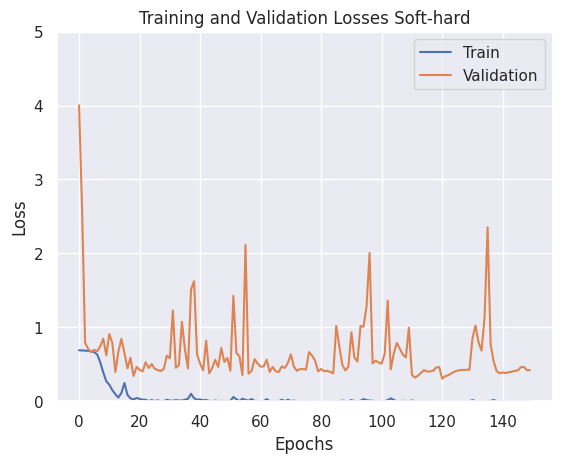

In [74]:
from datetime import datetime
import pytz
def ShowTrainLoss(train_losses,val_losses,save):
    # 日本時間のタイムゾーンを取得
    jst = pytz.timezone('Asia/Tokyo')

    # 現在の日本時間を取得
    now = datetime.now(jst)

    # 時刻を指定された形式の文字列に変換
    time = "_"+now.strftime("%Y%m%d%H%M")

    # 学習曲線の可視化

    title = 'Training and Validation Losses Soft-hard'
    plt.plot(train_losses, label='Train')
    plt.plot(val_losses, label='Validation')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.ylim(0,5)
    plt.legend()
    if save == True:
        plt.savefig("data/"+title+time+".pdf")

    plt.show()

ShowTrainLoss(train_losses,val_losses,False)

In [75]:

# dim=1 で行ごとの最大値に対する要素番号を取得（dim=0 は列ごと）
y_label = torch.argmax(y[0], dim=1)
# 予測値から最大となるクラスの番号を取り出した結果
y_label
# 目的変数
t
# 値が一致しているか確認
y_label == t
# int => float 
torch.sum(y_label == t) * 1.0
# 正解率
acc = torch.sum(y_label == t) * 1.0 / len(t)
acc


# 正解率の計算
def calc_acc(data_loader):
    
    with torch.no_grad():
        
        accs = [] # 各バッチごとの結果格納用
        
        for batch in data_loader:
            x, t = batch
            
            # x = torch.unsqueeze(x,1)
            
            x = x.to(device)
            t = t.to(device)
            y = net1(x)
            
            y_label = torch.argmax(y[0], dim=1)
            acc = torch.sum(y_label == t) * 1.0 / len(t)
            accs.append(acc)
            
    # 全体の平均を算出
    avg_acc = torch.tensor(accs).mean()
    print('Accuracy: {:.1f}%'.format(avg_acc * 100))
    
    return avg_acc
      
# 検証データで確認
calc_acc(val_loader)
# テストデータで確認
calc_acc(test_loader)


Accuracy: 90.9%
Accuracy: 91.6%


tensor(0.9164)

### material 1

In [76]:
# ラベルの指定
t_df = Dataset.matNum

# テンソル形式に変換
df_tenosor = torch.tensor(df, dtype=torch.float32)
df_tenosor = torch.unsqueeze(df_tenosor, 1)
label_tensor = torch.tensor(t_df, dtype=torch.int64)
print(df_tenosor.size())

# x と t を組み合わせて TensorDataset を作成
dataset = torch.utils.data.TensorDataset(df_tenosor, label_tensor)

# 各データセットのサンプル数を決定
# train : val: test = 50%　: 25% : 25%
n_train = int(len(dataset) * 0.5)
n_val = int(len(dataset) * 0.25)
n_test = len(dataset) - n_train - n_val
     
# それぞれのサンプル数を確認
print(n_train, n_val, n_test)

# ランダムに分割を行うため、シードを固定して再現性を確保
torch.manual_seed(0)

# データセットの分割
train, val, test = torch.utils.data.random_split(dataset, [n_train, n_val, n_test])

# バッチサイズ
batch_size = 25

      
# shuffle はデフォルトで False のため、学習データのみ True に指定
train_loader = torch.utils.data.DataLoader(train, batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val, batch_size)
test_loader = torch.utils.data.DataLoader(test, batch_size)

print(train_loader)

for batch in train_loader:
    print(batch)

torch.Size([1050, 1, 128, 130])
525 262 263
[tensor([[[[-15.7372, -12.7907, -12.2806,  ..., -16.2258, -12.1957, -14.6959],
          [-15.7418, -11.8346, -11.9373,  ..., -12.7932, -11.7111, -12.4843],
          [-22.5785, -21.3953, -21.5793,  ..., -20.6679, -21.5296, -17.3727],
          ...,
          [-58.1976, -55.0280, -55.0888,  ..., -53.4471, -52.7718, -53.7474],
          [-56.4661, -53.7698, -54.6103,  ..., -54.0908, -53.9045, -56.2288],
          [-57.3117, -54.9557, -55.6911,  ..., -54.7845, -54.3604, -56.0656]]],


        [[[ -5.8755,  -1.3352,   0.0000,  ...,  -8.2323,  -7.3307,  -8.7717],
          [ -7.0860,  -4.6320,  -2.7805,  ...,  -6.8078,  -5.4152,  -6.6856],
          [-14.4937, -18.4999, -18.0805,  ..., -15.1023, -14.4274, -11.6789],
          ...,
          [-50.1694, -46.3330, -44.8377,  ..., -47.9001, -46.6421, -47.7369],
          [-49.2638, -46.9567, -46.7122,  ..., -46.9204, -46.5079, -49.3187],
          [-46.9555, -45.9099, -47.1923,  ..., -47.8846, -48.97

In [77]:
matModel = shModel_trained

#パラメータの更新を許可
for param in matModel.parameters():
    param.requires_gred = True


# print(model.classifier)

# 出力層の最後だけ変更
# model.classifier[5] = torch.nn.Linear(1280,2)
matModel.classifier= nn.Sequential(
    nn.AdaptiveAvgPool2d(output_size=1),
    nn.Flatten(start_dim=1, end_dim=-1),
    nn.Linear(in_features=960, out_features=1280, bias=True),
    nn.Hardswish(),
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=527, bias=True),
    nn.Linear(in_features=527, out_features=176, bias=True),  # 新しい層
    nn.Linear(in_features=176, out_features=7, bias=True)  # 新しい層

)
print(matModel)

DyMN(
  (layers): ModuleList(
    (0): DY_Block(
      (exp_conv): DynamicWrapper(
        (module): Identity()
      )
      (exp_norm): Identity()
      (exp_act): DynamicWrapper(
        (module): Identity()
      )
      (depth_conv): DynamicConv(
        (residuals): Sequential(
          (0): Linear(in_features=32, out_features=4, bias=True)
        )
      )
      (depth_norm): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (depth_act): DyReLUB(
        (coef_net): Sequential(
          (0): Linear(in_features=32, out_features=64, bias=True)
        )
        (sigmoid): Sigmoid()
      )
      (ca): CoordAtt()
      (proj_conv): DynamicConv(
        (residuals): Sequential(
          (0): Linear(in_features=32, out_features=4, bias=True)
        )
      )
      (proj_norm): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (context_gen): ContextGen(
        (joint_conv): Conv2d(16, 32, kernel_size=(1, 1

In [78]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

# エポックの数
max_epoch = 150
     
# モデルの初期化
torch.manual_seed(0)

# GPU の設定状況に基づいたデバイスの選択
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
# モデルのインスタンス化とデバイスへの転送
net2 = matModel.cuda()

criterion = F.cross_entropy
  
# 最適化手法の選択
optimizer = torch.optim.SGD(net2.parameters(), lr=0.1)
# エポックごとの訓練データの損失と検証データの損失を保存するリスト
train_losses = []
val_losses = []

# 学習ループ
for epoch in range(max_epoch):
    train_epoch_loss = 0.0
    val_epoch_loss = 0.0
    
    # 訓練データでの学習
    net2.train()
    for batch in train_loader:
        x, t = batch
        x = x.to(device)
        t = t.to(device)
        optimizer.zero_grad()
        y = net2(x)
        loss = criterion(y[0], t)
        train_epoch_loss += loss.item()  # エポック全体の訓練データの損失に加算
        loss.backward()
        optimizer.step()
    
    # 訓練データでのエポックごとの平均損失を計算し保存
    train_epoch_loss /= len(train_loader)
    train_losses.append(train_epoch_loss)
    
    # 検証データでの評価
    net2.eval()
    with torch.no_grad():
        for batch in val_loader:
            x, t = batch
  
            x = x.to(device)
            t = t.to(device)
            y = net2(x)
            loss = criterion(y[0], t)
            val_epoch_loss += loss.item()  # エポック全体の検証データの損失に加算
       
    # 検証データでのエポックごとの平均損失を計算し保存
    val_epoch_loss /= len(val_loader)
    val_losses.append(val_epoch_loss)
    
    # エポックごとに損失を表示
    print(f'Epoch [{epoch+1}/{max_epoch}], Train Loss: {train_epoch_loss:.4f}, Validation Loss: {val_epoch_loss:.4f}')


matModel_trained = net2


cuda:0
Epoch [1/150], Train Loss: 1.9225, Validation Loss: 1.8997
Epoch [2/150], Train Loss: 1.7325, Validation Loss: 1.5695
Epoch [3/150], Train Loss: 1.3503, Validation Loss: 1.4211
Epoch [4/150], Train Loss: 1.2825, Validation Loss: 1.4517
Epoch [5/150], Train Loss: 1.2447, Validation Loss: 1.5265
Epoch [6/150], Train Loss: 1.1831, Validation Loss: 1.6691
Epoch [7/150], Train Loss: 1.2057, Validation Loss: 1.4472
Epoch [8/150], Train Loss: 1.1224, Validation Loss: 1.3016
Epoch [9/150], Train Loss: 1.0992, Validation Loss: 1.2933
Epoch [10/150], Train Loss: 1.0120, Validation Loss: 1.5142
Epoch [11/150], Train Loss: 1.0450, Validation Loss: 1.4261
Epoch [12/150], Train Loss: 0.9605, Validation Loss: 1.4747
Epoch [13/150], Train Loss: 0.9506, Validation Loss: 1.5995
Epoch [14/150], Train Loss: 0.9944, Validation Loss: 2.1991
Epoch [15/150], Train Loss: 0.8914, Validation Loss: 1.7537
Epoch [16/150], Train Loss: 0.9054, Validation Loss: 1.2582
Epoch [17/150], Train Loss: 0.8181, Valida

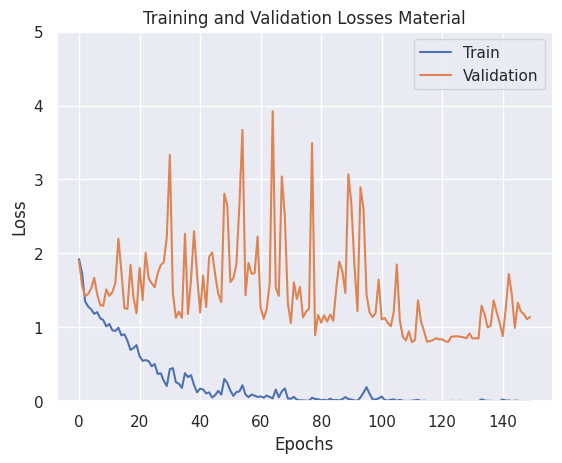

In [79]:
from datetime import datetime
import pytz
def ShowTrainLoss(train_losses,val_losses,save):
    # 日本時間のタイムゾーンを取得
    jst = pytz.timezone('Asia/Tokyo')

    # 現在の日本時間を取得
    now = datetime.now(jst)

    # 時刻を指定された形式の文字列に変換
    time = "_"+now.strftime("%Y%m%d%H%M")

    # 学習曲線の可視化

    title = 'Training and Validation Losses Material'
    plt.plot(train_losses, label='Train')
    plt.plot(val_losses, label='Validation')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.ylim(0,5)
    plt.legend()
    if save == True:
        plt.savefig("data/"+title+time+".pdf")

    plt.show()

ShowTrainLoss(train_losses,val_losses,True)

In [80]:

# dim=1 で行ごとの最大値に対する要素番号を取得（dim=0 は列ごと）
y_label = torch.argmax(y[0], dim=1)
# 予測値から最大となるクラスの番号を取り出した結果
y_label
# 目的変数
t
# 値が一致しているか確認
y_label == t
# int => float 
torch.sum(y_label == t) * 1.0
# 正解率
acc = torch.sum(y_label == t) * 1.0 / len(t)
acc


# 正解率の計算
def calc_acc(data_loader):
    
    with torch.no_grad():
        
        accs = [] # 各バッチごとの結果格納用
        
        for batch in data_loader:
            x, t = batch
            
            # x = torch.unsqueeze(x,1)
            
            x = x.to(device)
            t = t.to(device)
            y = net2(x)
            
            y_label = torch.argmax(y[0], dim=1)
            acc = torch.sum(y_label == t) * 1.0 / len(t)
            accs.append(acc)
            
    # 全体の平均を算出
    avg_acc = torch.tensor(accs).mean()
    print('Accuracy: {:.1f}%'.format(avg_acc * 100))
    
    return avg_acc
      
# 検証データで確認
calc_acc(val_loader)
# テストデータで確認
calc_acc(test_loader)

Accuracy: 80.3%
Accuracy: 82.6%


tensor(0.8257)

### object 1

In [81]:
# ラベルの指定
t_df = Dataset.objectNum

# テンソル形式に変換
df_tenosor = torch.tensor(df, dtype=torch.float32)
df_tenosor = torch.unsqueeze(df_tenosor, 1)
label_tensor = torch.tensor(t_df, dtype=torch.int64)
print(df_tenosor.size())

# x と t を組み合わせて TensorDataset を作成
dataset = torch.utils.data.TensorDataset(df_tenosor, label_tensor)

# 各データセットのサンプル数を決定
# train : val: test = 50%　: 25% : 25%
n_train = int(len(dataset) * 0.5)
n_val = int(len(dataset) * 0.25)
n_test = len(dataset) - n_train - n_val
     
# それぞれのサンプル数を確認
print(n_train, n_val, n_test)

# ランダムに分割を行うため、シードを固定して再現性を確保
torch.manual_seed(0)

# データセットの分割
train, val, test = torch.utils.data.random_split(dataset, [n_train, n_val, n_test])

# バッチサイズ
batch_size = 25

      
# shuffle はデフォルトで False のため、学習データのみ True に指定
train_loader = torch.utils.data.DataLoader(train, batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val, batch_size)
test_loader = torch.utils.data.DataLoader(test, batch_size)

print(train_loader)

for batch in train_loader:
    print(batch)

torch.Size([1050, 1, 128, 130])
525 262 263
[tensor([[[[-15.7372, -12.7907, -12.2806,  ..., -16.2258, -12.1957, -14.6959],
          [-15.7418, -11.8346, -11.9373,  ..., -12.7932, -11.7111, -12.4843],
          [-22.5785, -21.3953, -21.5793,  ..., -20.6679, -21.5296, -17.3727],
          ...,
          [-58.1976, -55.0280, -55.0888,  ..., -53.4471, -52.7718, -53.7474],
          [-56.4661, -53.7698, -54.6103,  ..., -54.0908, -53.9045, -56.2288],
          [-57.3117, -54.9557, -55.6911,  ..., -54.7845, -54.3604, -56.0656]]],


        [[[ -5.8755,  -1.3352,   0.0000,  ...,  -8.2323,  -7.3307,  -8.7717],
          [ -7.0860,  -4.6320,  -2.7805,  ...,  -6.8078,  -5.4152,  -6.6856],
          [-14.4937, -18.4999, -18.0805,  ..., -15.1023, -14.4274, -11.6789],
          ...,
          [-50.1694, -46.3330, -44.8377,  ..., -47.9001, -46.6421, -47.7369],
          [-49.2638, -46.9567, -46.7122,  ..., -46.9204, -46.5079, -49.3187],
          [-46.9555, -45.9099, -47.1923,  ..., -47.8846, -48.97

In [82]:
objModel = matModel_trained

#パラメータの更新を許可
for param in objModel.parameters():
    param.requires_gred = True


# print(model.classifier)

# 出力層の最後だけ変更
# model.classifier[5] = torch.nn.Linear(1280,2)
objModel.classifier= nn.Sequential(
    nn.AdaptiveAvgPool2d(output_size=1),
    nn.Flatten(start_dim=1, end_dim=-1),
    nn.Linear(in_features=960, out_features=1280, bias=True),
    nn.Hardswish(),
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=527, bias=True),
    nn.Linear(in_features=527, out_features=176, bias=True),  # 新しい層
    nn.Linear(in_features=176, out_features=21, bias=True)  # 新しい層

)
print(objModel)

DyMN(
  (layers): ModuleList(
    (0): DY_Block(
      (exp_conv): DynamicWrapper(
        (module): Identity()
      )
      (exp_norm): Identity()
      (exp_act): DynamicWrapper(
        (module): Identity()
      )
      (depth_conv): DynamicConv(
        (residuals): Sequential(
          (0): Linear(in_features=32, out_features=4, bias=True)
        )
      )
      (depth_norm): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (depth_act): DyReLUB(
        (coef_net): Sequential(
          (0): Linear(in_features=32, out_features=64, bias=True)
        )
        (sigmoid): Sigmoid()
      )
      (ca): CoordAtt()
      (proj_conv): DynamicConv(
        (residuals): Sequential(
          (0): Linear(in_features=32, out_features=4, bias=True)
        )
      )
      (proj_norm): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (context_gen): ContextGen(
        (joint_conv): Conv2d(16, 32, kernel_size=(1, 1

In [83]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

# エポックの数
max_epoch = 150
     
# モデルの初期化
torch.manual_seed(0)

# GPU の設定状況に基づいたデバイスの選択
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
# モデルのインスタンス化とデバイスへの転送
net3 = objModel.cuda()

criterion = F.cross_entropy
  
# 最適化手法の選択
optimizer = torch.optim.SGD(net3.parameters(), lr=0.1)
# エポックごとの訓練データの損失と検証データの損失を保存するリスト
train_losses = []
val_losses = []

# 学習ループ
for epoch in range(max_epoch):
    train_epoch_loss = 0.0
    val_epoch_loss = 0.0
    
    # 訓練データでの学習
    net3.train()
    for batch in train_loader:
        x, t = batch
        x = x.to(device)
        t = t.to(device)
        optimizer.zero_grad()
        y = net3(x)
        loss = criterion(y[0], t)
        train_epoch_loss += loss.item()  # エポック全体の訓練データの損失に加算
        loss.backward()
        optimizer.step()
    
    # 訓練データでのエポックごとの平均損失を計算し保存
    train_epoch_loss /= len(train_loader)
    train_losses.append(train_epoch_loss)
    
    # 検証データでの評価
    net3.eval()
    with torch.no_grad():
        for batch in val_loader:
            x, t = batch
  
            x = x.to(device)
            t = t.to(device)
            y = net3(x)
            loss = criterion(y[0], t)
            val_epoch_loss += loss.item()  # エポック全体の検証データの損失に加算
       
    # 検証データでのエポックごとの平均損失を計算し保存
    val_epoch_loss /= len(val_loader)
    val_losses.append(val_epoch_loss)
    
    # エポックごとに損失を表示
    print(f'Epoch [{epoch+1}/{max_epoch}], Train Loss: {train_epoch_loss:.4f}, Validation Loss: {val_epoch_loss:.4f}')


objModel_trained = net3


cuda:0
Epoch [1/150], Train Loss: 3.0274, Validation Loss: 3.0151
Epoch [2/150], Train Loss: 2.9547, Validation Loss: 2.8859
Epoch [3/150], Train Loss: 2.6866, Validation Loss: 2.6301
Epoch [4/150], Train Loss: 2.3931, Validation Loss: 2.6173
Epoch [5/150], Train Loss: 2.1942, Validation Loss: 2.3067
Epoch [6/150], Train Loss: 1.8527, Validation Loss: 1.9830
Epoch [7/150], Train Loss: 1.5926, Validation Loss: 1.8580
Epoch [8/150], Train Loss: 1.5482, Validation Loss: 1.8910
Epoch [9/150], Train Loss: 1.4847, Validation Loss: 1.9775
Epoch [10/150], Train Loss: 1.3705, Validation Loss: 1.9484
Epoch [11/150], Train Loss: 1.4235, Validation Loss: 1.8857
Epoch [12/150], Train Loss: 1.3343, Validation Loss: 1.7861
Epoch [13/150], Train Loss: 1.2945, Validation Loss: 1.7130
Epoch [14/150], Train Loss: 1.2614, Validation Loss: 1.8215
Epoch [15/150], Train Loss: 1.1752, Validation Loss: 1.7135
Epoch [16/150], Train Loss: 1.2049, Validation Loss: 2.0856
Epoch [17/150], Train Loss: 1.0290, Valida

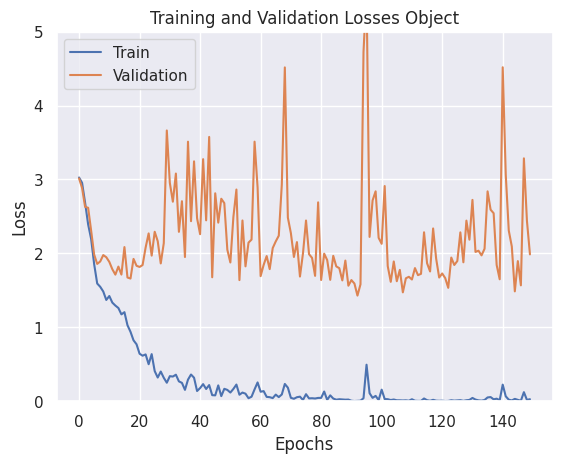

In [84]:
from datetime import datetime
import pytz
def ShowTrainLoss(train_losses,val_losses,save):
    # 日本時間のタイムゾーンを取得
    jst = pytz.timezone('Asia/Tokyo')

    # 現在の日本時間を取得
    now = datetime.now(jst)

    # 時刻を指定された形式の文字列に変換
    time = "_"+now.strftime("%Y%m%d%H%M")

    # 学習曲線の可視化

    title = 'Training and Validation Losses Object'
    plt.plot(train_losses, label='Train')
    plt.plot(val_losses, label='Validation')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.ylim(0,5)
    plt.legend()
    if save == True:
        plt.savefig("data/"+title+time+".pdf")

    plt.show()

ShowTrainLoss(train_losses,val_losses,True)

In [85]:

# dim=1 で行ごとの最大値に対する要素番号を取得（dim=0 は列ごと）
y_label = torch.argmax(y[0], dim=1)
# 予測値から最大となるクラスの番号を取り出した結果
y_label
# 目的変数
t
# 値が一致しているか確認
y_label == t
# int => float 
torch.sum(y_label == t) * 1.0
# 正解率
acc = torch.sum(y_label == t) * 1.0 / len(t)
acc


# 正解率の計算
def calc_acc(data_loader):
    
    with torch.no_grad():
        
        accs = [] # 各バッチごとの結果格納用
        
        for batch in data_loader:
            x, t = batch
            
            # x = torch.unsqueeze(x,1)
            
            x = x.to(device)
            t = t.to(device)
            y = net3(x)
            
            y_label = torch.argmax(y[0], dim=1)
            acc = torch.sum(y_label == t) * 1.0 / len(t)
            accs.append(acc)
            
    # 全体の平均を算出
    avg_acc = torch.tensor(accs).mean()
    print('Accuracy: {:.1f}%'.format(avg_acc * 100))
    
    return avg_acc
      
# 検証データで確認
calc_acc(val_loader)
# テストデータで確認
calc_acc(test_loader)

Accuracy: 66.8%
Accuracy: 65.9%


tensor(0.6590)

### soft-hard 2

In [86]:
# ラベルの指定
t_df = Dataset.shNum

# テンソル形式に変換
df_tenosor = torch.tensor(df, dtype=torch.float32)
df_tenosor = torch.unsqueeze(df_tenosor, 1)
label_tensor = torch.tensor(t_df, dtype=torch.int64)
print(df_tenosor.size())

# x と t を組み合わせて TensorDataset を作成
dataset = torch.utils.data.TensorDataset(df_tenosor, label_tensor)

# 各データセットのサンプル数を決定
# train : val: test = 50%　: 25% : 25%
n_train = int(len(dataset) * 0.5)
n_val = int(len(dataset) * 0.25)
n_test = len(dataset) - n_train - n_val
     
# それぞれのサンプル数を確認
print(n_train, n_val, n_test)

# ランダムに分割を行うため、シードを固定して再現性を確保
torch.manual_seed(0)

# データセットの分割
train, val, test = torch.utils.data.random_split(dataset, [n_train, n_val, n_test])

# バッチサイズ
batch_size = 25

      
# shuffle はデフォルトで False のため、学習データのみ True に指定
train_loader = torch.utils.data.DataLoader(train, batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val, batch_size)
test_loader = torch.utils.data.DataLoader(test, batch_size)

print(train_loader)

for batch in train_loader:
    print(batch)

torch.Size([1050, 1, 128, 130])
525 262 263
[tensor([[[[-15.7372, -12.7907, -12.2806,  ..., -16.2258, -12.1957, -14.6959],
          [-15.7418, -11.8346, -11.9373,  ..., -12.7932, -11.7111, -12.4843],
          [-22.5785, -21.3953, -21.5793,  ..., -20.6679, -21.5296, -17.3727],
          ...,
          [-58.1976, -55.0280, -55.0888,  ..., -53.4471, -52.7718, -53.7474],
          [-56.4661, -53.7698, -54.6103,  ..., -54.0908, -53.9045, -56.2288],
          [-57.3117, -54.9557, -55.6911,  ..., -54.7845, -54.3604, -56.0656]]],


        [[[ -5.8755,  -1.3352,   0.0000,  ...,  -8.2323,  -7.3307,  -8.7717],
          [ -7.0860,  -4.6320,  -2.7805,  ...,  -6.8078,  -5.4152,  -6.6856],
          [-14.4937, -18.4999, -18.0805,  ..., -15.1023, -14.4274, -11.6789],
          ...,
          [-50.1694, -46.3330, -44.8377,  ..., -47.9001, -46.6421, -47.7369],
          [-49.2638, -46.9567, -46.7122,  ..., -46.9204, -46.5079, -49.3187],
          [-46.9555, -45.9099, -47.1923,  ..., -47.8846, -48.97

In [87]:
shModel_2 = objModel_trained

#パラメータの更新を許可
for param in shModel_2.parameters():
    param.requires_gred = False


# print(model.classifier)

# 出力層の最後だけ変更
# model.classifier[5] = torch.nn.Linear(1280,2)
shModel_2.classifier= nn.Sequential(
    nn.AdaptiveAvgPool2d(output_size=1),
    nn.Flatten(start_dim=1, end_dim=-1),
    nn.Linear(in_features=960, out_features=1280, bias=False),
    nn.Hardswish(),
    nn.Dropout(p=0.2, inplace=False),
    nn.Linear(in_features=1280, out_features=527, bias=False),
    nn.Linear(in_features=527, out_features=176, bias=False),  # 新しい層
    nn.Linear(in_features=176, out_features=21, bias=False),  # 新しい層
    nn.ReLU(),
    nn.Linear(in_features=21, out_features=2, bias=True),  # 新しい層


)
print(shModel_2)

DyMN(
  (layers): ModuleList(
    (0): DY_Block(
      (exp_conv): DynamicWrapper(
        (module): Identity()
      )
      (exp_norm): Identity()
      (exp_act): DynamicWrapper(
        (module): Identity()
      )
      (depth_conv): DynamicConv(
        (residuals): Sequential(
          (0): Linear(in_features=32, out_features=4, bias=True)
        )
      )
      (depth_norm): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (depth_act): DyReLUB(
        (coef_net): Sequential(
          (0): Linear(in_features=32, out_features=64, bias=True)
        )
        (sigmoid): Sigmoid()
      )
      (ca): CoordAtt()
      (proj_conv): DynamicConv(
        (residuals): Sequential(
          (0): Linear(in_features=32, out_features=4, bias=True)
        )
      )
      (proj_norm): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (context_gen): ContextGen(
        (joint_conv): Conv2d(16, 32, kernel_size=(1, 1

In [88]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

# エポックの数
max_epoch = 50
     
# モデルの初期化
torch.manual_seed(0)

# GPU の設定状況に基づいたデバイスの選択
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
# モデルのインスタンス化とデバイスへの転送
net4 = shModel_2.cuda()

criterion = F.cross_entropy
  
# 最適化手法の選択
optimizer = torch.optim.SGD(net4.parameters(), lr=0.1)
# エポックごとの訓練データの損失と検証データの損失を保存するリスト
train_losses = []
val_losses = []

# 学習ループ
for epoch in range(max_epoch):
    train_epoch_loss = 0.0
    val_epoch_loss = 0.0
    
    # 訓練データでの学習
    net4.train()
    for batch in train_loader:
        x, t = batch
        x = x.to(device)
        t = t.to(device)
        optimizer.zero_grad()
        y = net4(x)
        loss = criterion(y[0], t)
        train_epoch_loss += loss.item()  # エポック全体の訓練データの損失に加算
        loss.backward()
        optimizer.step()
    
    # 訓練データでのエポックごとの平均損失を計算し保存
    train_epoch_loss /= len(train_loader)
    train_losses.append(train_epoch_loss)
    
    # 検証データでの評価
    net4.eval()
    with torch.no_grad():
        for batch in val_loader:
            x, t = batch
  
            x = x.to(device)
            t = t.to(device)
            y = net4(x)
            loss = criterion(y[0], t)
            val_epoch_loss += loss.item()  # エポック全体の検証データの損失に加算
       
    # 検証データでのエポックごとの平均損失を計算し保存
    val_epoch_loss /= len(val_loader)
    val_losses.append(val_epoch_loss)
    
    # エポックごとに損失を表示
    print(f'Epoch [{epoch+1}/{max_epoch}], Train Loss: {train_epoch_loss:.4f}, Validation Loss: {val_epoch_loss:.4f}')

shModel_2_trained = net4


cuda:0
Epoch [1/50], Train Loss: 0.6862, Validation Loss: 0.6715
Epoch [2/50], Train Loss: 0.6498, Validation Loss: 0.6256
Epoch [3/50], Train Loss: 0.5443, Validation Loss: 0.4785
Epoch [4/50], Train Loss: 0.3440, Validation Loss: 0.3357
Epoch [5/50], Train Loss: 0.1750, Validation Loss: 0.2275
Epoch [6/50], Train Loss: 0.0562, Validation Loss: 0.2037
Epoch [7/50], Train Loss: 0.0229, Validation Loss: 0.2275
Epoch [8/50], Train Loss: 0.0236, Validation Loss: 0.2231
Epoch [9/50], Train Loss: 0.0155, Validation Loss: 0.2196
Epoch [10/50], Train Loss: 0.0032, Validation Loss: 0.2230
Epoch [11/50], Train Loss: 0.0085, Validation Loss: 0.2698
Epoch [12/50], Train Loss: 0.0024, Validation Loss: 0.2611
Epoch [13/50], Train Loss: 0.0019, Validation Loss: 0.2638
Epoch [14/50], Train Loss: 0.0013, Validation Loss: 0.2657
Epoch [15/50], Train Loss: 0.0021, Validation Loss: 0.2665
Epoch [16/50], Train Loss: 0.0113, Validation Loss: 0.2932
Epoch [17/50], Train Loss: 0.0034, Validation Loss: 0.2772

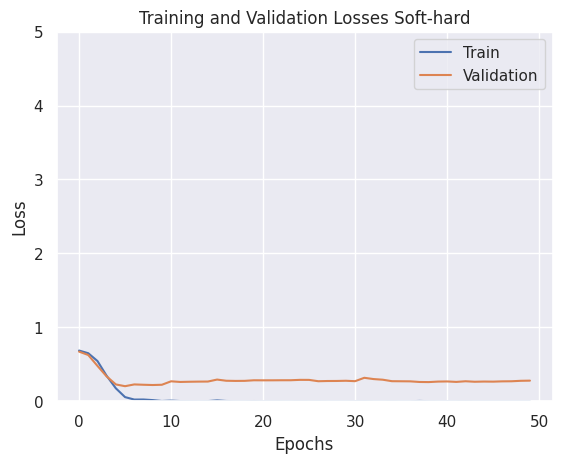

In [89]:
from datetime import datetime
import pytz
def ShowTrainLoss(train_losses,val_losses,save):
    # 日本時間のタイムゾーンを取得
    jst = pytz.timezone('Asia/Tokyo')

    # 現在の日本時間を取得
    now = datetime.now(jst)

    # 時刻を指定された形式の文字列に変換
    time = "_"+now.strftime("%Y%m%d%H%M")

    # 学習曲線の可視化

    title = 'Training and Validation Losses Soft-hard'
    plt.plot(train_losses, label='Train')
    plt.plot(val_losses, label='Validation')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.ylim(0,5)
    plt.legend()
    if save == True:
        plt.savefig("data/"+title+time+".pdf")

    plt.show()

ShowTrainLoss(train_losses,val_losses,False)

In [90]:

# dim=1 で行ごとの最大値に対する要素番号を取得（dim=0 は列ごと）
y_label = torch.argmax(y[0], dim=1)
# 予測値から最大となるクラスの番号を取り出した結果
y_label
# 目的変数
t
# 値が一致しているか確認
y_label == t
# int => float 
torch.sum(y_label == t) * 1.0
# 正解率
acc = torch.sum(y_label == t) * 1.0 / len(t)
acc


# 正解率の計算
def calc_acc(data_loader):
    
    with torch.no_grad():
        
        accs = [] # 各バッチごとの結果格納用
        
        for batch in data_loader:
            x, t = batch
            
            # x = torch.unsqueeze(x,1)
            
            x = x.to(device)
            t = t.to(device)
            y = net4(x)
            
            y_label = torch.argmax(y[0], dim=1)
            acc = torch.sum(y_label == t) * 1.0 / len(t)
            accs.append(acc)
            
    # 全体の平均を算出
    avg_acc = torch.tensor(accs).mean()
    print('Accuracy: {:.1f}%'.format(avg_acc * 100))
    
    return avg_acc
      
# 検証データで確認
calc_acc(val_loader)
# テストデータで確認
calc_acc(test_loader)


Accuracy: 94.5%
Accuracy: 96.0%


tensor(0.9600)

### material 2

In [91]:
# ラベルの指定
t_df = Dataset.matNum

# テンソル形式に変換
df_tenosor = torch.tensor(df, dtype=torch.float32)
df_tenosor = torch.unsqueeze(df_tenosor, 1)
label_tensor = torch.tensor(t_df, dtype=torch.int64)
print(df_tenosor.size())

# x と t を組み合わせて TensorDataset を作成
dataset = torch.utils.data.TensorDataset(df_tenosor, label_tensor)

# 各データセットのサンプル数を決定
# train : val: test = 50%　: 25% : 25%
n_train = int(len(dataset) * 0.5)
n_val = int(len(dataset) * 0.25)
n_test = len(dataset) - n_train - n_val
     
# それぞれのサンプル数を確認
print(n_train, n_val, n_test)

# ランダムに分割を行うため、シードを固定して再現性を確保
torch.manual_seed(0)

# データセットの分割
train, val, test = torch.utils.data.random_split(dataset, [n_train, n_val, n_test])

# バッチサイズ
batch_size = 25

      
# shuffle はデフォルトで False のため、学習データのみ True に指定
train_loader = torch.utils.data.DataLoader(train, batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val, batch_size)
test_loader = torch.utils.data.DataLoader(test, batch_size)

print(train_loader)

for batch in train_loader:
    print(batch)

torch.Size([1050, 1, 128, 130])
525 262 263
[tensor([[[[-15.7372, -12.7907, -12.2806,  ..., -16.2258, -12.1957, -14.6959],
          [-15.7418, -11.8346, -11.9373,  ..., -12.7932, -11.7111, -12.4843],
          [-22.5785, -21.3953, -21.5793,  ..., -20.6679, -21.5296, -17.3727],
          ...,
          [-58.1976, -55.0280, -55.0888,  ..., -53.4471, -52.7718, -53.7474],
          [-56.4661, -53.7698, -54.6103,  ..., -54.0908, -53.9045, -56.2288],
          [-57.3117, -54.9557, -55.6911,  ..., -54.7845, -54.3604, -56.0656]]],


        [[[ -5.8755,  -1.3352,   0.0000,  ...,  -8.2323,  -7.3307,  -8.7717],
          [ -7.0860,  -4.6320,  -2.7805,  ...,  -6.8078,  -5.4152,  -6.6856],
          [-14.4937, -18.4999, -18.0805,  ..., -15.1023, -14.4274, -11.6789],
          ...,
          [-50.1694, -46.3330, -44.8377,  ..., -47.9001, -46.6421, -47.7369],
          [-49.2638, -46.9567, -46.7122,  ..., -46.9204, -46.5079, -49.3187],
          [-46.9555, -45.9099, -47.1923,  ..., -47.8846, -48.97

In [92]:
matModel_2 = shModel_2_trained

#パラメータの更新を許可
for param in matModel_2.parameters():
    param.requires_gred = False


# print(model.classifier)

# 出力層の最後だけ変更
# model.classifier[5] = torch.nn.Linear(1280,2)
matModel_2.classifier= nn.Sequential(
    nn.AdaptiveAvgPool2d(output_size=1),
    nn.Flatten(start_dim=1, end_dim=-1),
    nn.Linear(in_features=960, out_features=1280, bias=False),
    nn.Hardswish(),
    nn.Dropout(p=0.2, inplace=False),
    nn.Linear(in_features=1280, out_features=527, bias=False),
    nn.Linear(in_features=527, out_features=176, bias=False),  # 新しい層
    nn.Linear(in_features=176, out_features=21, bias=False),  # 新しい層
    nn.ReLU(),
    nn.Linear(in_features=21, out_features=2, bias=True),  # 新しい層
    nn.ReLU(),
    nn.Linear(in_features=2, out_features=21, bias=True),  # 新しい層
    nn.ReLU(),
    nn.Linear(in_features=21, out_features=7, bias=True),  # 新しい層   


)
print(shModel_2)

DyMN(
  (layers): ModuleList(
    (0): DY_Block(
      (exp_conv): DynamicWrapper(
        (module): Identity()
      )
      (exp_norm): Identity()
      (exp_act): DynamicWrapper(
        (module): Identity()
      )
      (depth_conv): DynamicConv(
        (residuals): Sequential(
          (0): Linear(in_features=32, out_features=4, bias=True)
        )
      )
      (depth_norm): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (depth_act): DyReLUB(
        (coef_net): Sequential(
          (0): Linear(in_features=32, out_features=64, bias=True)
        )
        (sigmoid): Sigmoid()
      )
      (ca): CoordAtt()
      (proj_conv): DynamicConv(
        (residuals): Sequential(
          (0): Linear(in_features=32, out_features=4, bias=True)
        )
      )
      (proj_norm): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (context_gen): ContextGen(
        (joint_conv): Conv2d(16, 32, kernel_size=(1, 1

In [93]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

# エポックの数
epoch = 0
max_epoch = 1000     
# モデルの初期化
torch.manual_seed(0)

# GPU の設定状況に基づいたデバイスの選択
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
# モデルのインスタンス化とデバイスへの転送
net5 = matModel_2.cuda()

criterion = F.cross_entropy
  
# 最適化手法の選択
optimizer = torch.optim.SGD(net5.parameters(), lr=0.1)
# エポックごとの訓練データの損失と検証データの損失を保存するリスト
train_losses = []
val_losses = []

# 学習ループ
# for epoch in range(max_epoch):
train_epoch_loss = 1.0
val_epoch_loss = 1.0

while (train_epoch_loss > 0.1 or val_epoch_loss  > 0.1) and epoch<max_epoch:
    train_epoch_loss = 0.0
    val_epoch_loss = 0.0
    
    # 訓練データでの学習
    net5.train()
    for batch in train_loader:
        x, t = batch
        x = x.to(device)
        t = t.to(device)
        optimizer.zero_grad()
        y = net5(x)
        loss = criterion(y[0], t)
        train_epoch_loss += loss.item()  # エポック全体の訓練データの損失に加算
        loss.backward()
        optimizer.step()
    
    # 訓練データでのエポックごとの平均損失を計算し保存
    train_epoch_loss /= len(train_loader)
    train_losses.append(train_epoch_loss)
    
    # 検証データでの評価
    net5.eval()
    with torch.no_grad():
        for batch in val_loader:
            x, t = batch
  
            x = x.to(device)
            t = t.to(device)
            y = net5(x)
            loss = criterion(y[0], t)
            val_epoch_loss += loss.item()  # エポック全体の検証データの損失に加算
       
    # 検証データでのエポックごとの平均損失を計算し保存
    val_epoch_loss /= len(val_loader)
    val_losses.append(val_epoch_loss)
    
    # エポックごとに損失を表示
    print(f'Epoch [{epoch+1}/{max_epoch}], Train Loss: {train_epoch_loss:.4f}, Validation Loss: {val_epoch_loss:.4f}')
    epoch+=1

matModel_2_trained = net5


cuda:0
Epoch [1/50], Train Loss: 1.9525, Validation Loss: 1.9592
Epoch [2/50], Train Loss: 1.9471, Validation Loss: 1.9585
Epoch [3/50], Train Loss: 1.9461, Validation Loss: 1.9569
Epoch [4/50], Train Loss: 1.9448, Validation Loss: 1.9572
Epoch [5/50], Train Loss: 1.9446, Validation Loss: 1.9574
Epoch [6/50], Train Loss: 1.9440, Validation Loss: 1.9571
Epoch [7/50], Train Loss: 1.9433, Validation Loss: 1.9544
Epoch [8/50], Train Loss: 1.9409, Validation Loss: 1.9539
Epoch [9/50], Train Loss: 1.9378, Validation Loss: 1.9507
Epoch [10/50], Train Loss: 1.9350, Validation Loss: 1.9490
Epoch [11/50], Train Loss: 1.9290, Validation Loss: 1.9436
Epoch [12/50], Train Loss: 1.9150, Validation Loss: 1.9257
Epoch [13/50], Train Loss: 1.8925, Validation Loss: 1.9002
Epoch [14/50], Train Loss: 1.8424, Validation Loss: 1.8398
Epoch [15/50], Train Loss: 1.7376, Validation Loss: 1.6971
Epoch [16/50], Train Loss: 1.5226, Validation Loss: 1.4472
Epoch [17/50], Train Loss: 1.2060, Validation Loss: 1.2053

In [94]:
matModel_2_trained = net5


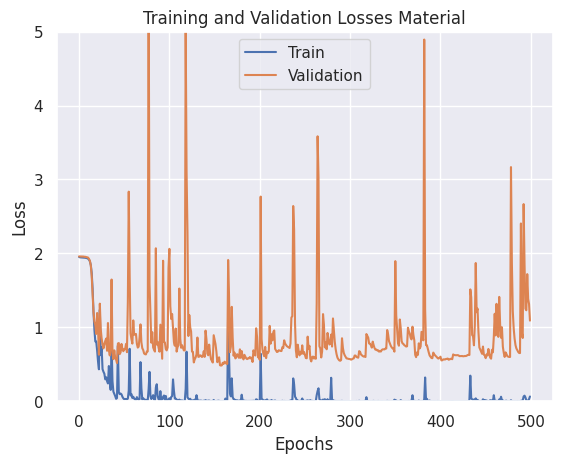

In [95]:
from datetime import datetime
import pytz
def ShowTrainLoss(train_losses,val_losses,save):
    # 日本時間のタイムゾーンを取得
    jst = pytz.timezone('Asia/Tokyo')

    # 現在の日本時間を取得
    now = datetime.now(jst)

    # 時刻を指定された形式の文字列に変換
    time = "_"+now.strftime("%Y%m%d%H%M")

    # 学習曲線の可視化

    title = 'Training and Validation Losses Material'
    plt.plot(train_losses, label='Train')
    plt.plot(val_losses, label='Validation')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.ylim(0,5)
    plt.legend()
    if save == True:
        plt.savefig("data/"+title+time+".pdf")

    plt.show()

ShowTrainLoss(train_losses,val_losses,True)

In [96]:

# dim=1 で行ごとの最大値に対する要素番号を取得（dim=0 は列ごと）
y_label = torch.argmax(y[0], dim=1)
# 予測値から最大となるクラスの番号を取り出した結果
y_label
# 目的変数
t
# 値が一致しているか確認
y_label == t
# int => float 
torch.sum(y_label == t) * 1.0
# 正解率
acc = torch.sum(y_label == t) * 1.0 / len(t)
acc


# 正解率の計算
def calc_acc(data_loader):
    
    with torch.no_grad():
        
        accs = [] # 各バッチごとの結果格納用
        
        for batch in data_loader:
            x, t = batch
            
            # x = torch.unsqueeze(x,1)
            
            x = x.to(device)
            t = t.to(device)
            y = net5(x)
            
            y_label = torch.argmax(y[0], dim=1)
            acc = torch.sum(y_label == t) * 1.0 / len(t)
            accs.append(acc)
            
    # 全体の平均を算出
    avg_acc = torch.tensor(accs).mean()
    print('Accuracy: {:.1f}%'.format(avg_acc * 100))
    
    return avg_acc
      
# 検証データで確認
calc_acc(val_loader)
# テストデータで確認
calc_acc(test_loader)

Accuracy: 81.4%
Accuracy: 83.0%


tensor(0.8297)

### object 2

In [122]:
# ラベルの指定
t_df = Dataset.objectNum

# テンソル形式に変換
df_tenosor = torch.tensor(df, dtype=torch.float32)
df_tenosor = torch.unsqueeze(df_tenosor, 1)
label_tensor = torch.tensor(t_df, dtype=torch.int64)
print(df_tenosor.size())

# x と t を組み合わせて TensorDataset を作成
dataset = torch.utils.data.TensorDataset(df_tenosor, label_tensor)

# 各データセットのサンプル数を決定
# train : val: test = 50%　: 25% : 25%
n_train = int(len(dataset) * 0.5)
n_val = int(len(dataset) * 0.25)
n_test = len(dataset) - n_train - n_val
     
# それぞれのサンプル数を確認
print(n_train, n_val, n_test)

# ランダムに分割を行うため、シードを固定して再現性を確保
torch.manual_seed(0)

# データセットの分割
train, val, test = torch.utils.data.random_split(dataset, [n_train, n_val, n_test])

# バッチサイズ
batch_size = 25

      
# shuffle はデフォルトで False のため、学習データのみ True に指定
train_loader = torch.utils.data.DataLoader(train, batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val, batch_size)
test_loader = torch.utils.data.DataLoader(test, batch_size)

print(train_loader)

for batch in train_loader:
    print(batch)

torch.Size([1050, 1, 128, 130])
525 262 263
[tensor([[[[-15.7372, -12.7907, -12.2806,  ..., -16.2258, -12.1957, -14.6959],
          [-15.7418, -11.8346, -11.9373,  ..., -12.7932, -11.7111, -12.4843],
          [-22.5785, -21.3953, -21.5793,  ..., -20.6679, -21.5296, -17.3727],
          ...,
          [-58.1976, -55.0280, -55.0888,  ..., -53.4471, -52.7718, -53.7474],
          [-56.4661, -53.7698, -54.6103,  ..., -54.0908, -53.9045, -56.2288],
          [-57.3117, -54.9557, -55.6911,  ..., -54.7845, -54.3604, -56.0656]]],


        [[[ -5.8755,  -1.3352,   0.0000,  ...,  -8.2323,  -7.3307,  -8.7717],
          [ -7.0860,  -4.6320,  -2.7805,  ...,  -6.8078,  -5.4152,  -6.6856],
          [-14.4937, -18.4999, -18.0805,  ..., -15.1023, -14.4274, -11.6789],
          ...,
          [-50.1694, -46.3330, -44.8377,  ..., -47.9001, -46.6421, -47.7369],
          [-49.2638, -46.9567, -46.7122,  ..., -46.9204, -46.5079, -49.3187],
          [-46.9555, -45.9099, -47.1923,  ..., -47.8846, -48.97

In [123]:
objModel_2 = matModel_2_trained

# パラメータの更新を許可
for param in objModel_2.parameters():
    param.requires_grad = False  # requires_gred -> requires_grad

# 新しい層の追加とBatch Normalizationの導入
objModel_2.classifier = nn.Sequential(
    nn.AdaptiveAvgPool2d(output_size=1),
    nn.Flatten(start_dim=1, end_dim=-1),
    nn.Linear(in_features=960, out_features=1280, bias=False),
    nn.BatchNorm1d(1280),
    nn.Hardswish(),
    nn.Dropout(p=0.2, inplace=False),
    nn.Linear(in_features=1280, out_features=527, bias=False),
    nn.BatchNorm1d(527),
    nn.ReLU(),
    nn.Linear(in_features=527, out_features=176, bias=False),
    nn.BatchNorm1d(176),
    nn.ReLU(),
    nn.Linear(in_features=176, out_features=21, bias=False),
    nn.BatchNorm1d(21),
    nn.ReLU(),
    nn.Linear(in_features=21, out_features=2, bias=False),
    nn.BatchNorm1d(2),
    nn.ReLU(),
    nn.Linear(in_features=2, out_features=21, bias=False),
    nn.BatchNorm1d(21),
    nn.ReLU(),
    nn.Linear(in_features=21, out_features=6, bias=False),
    nn.BatchNorm1d(6),
    nn.ReLU(),
    nn.Linear(in_features=6, out_features=21, bias=True),
    nn.BatchNorm1d(21),
    nn.ReLU(),
    nn.Linear(in_features=21, out_features=21, bias=True),
)

print(objModel_2)


DyMN(
  (layers): ModuleList(
    (0): DY_Block(
      (exp_conv): DynamicWrapper(
        (module): Identity()
      )
      (exp_norm): Identity()
      (exp_act): DynamicWrapper(
        (module): Identity()
      )
      (depth_conv): DynamicConv(
        (residuals): Sequential(
          (0): Linear(in_features=32, out_features=4, bias=True)
        )
      )
      (depth_norm): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (depth_act): DyReLUB(
        (coef_net): Sequential(
          (0): Linear(in_features=32, out_features=64, bias=True)
        )
        (sigmoid): Sigmoid()
      )
      (ca): CoordAtt()
      (proj_conv): DynamicConv(
        (residuals): Sequential(
          (0): Linear(in_features=32, out_features=4, bias=True)
        )
      )
      (proj_norm): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (context_gen): ContextGen(
        (joint_conv): Conv2d(16, 32, kernel_size=(1, 1

In [124]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

# エポックの数
epoch = 0
max_epoch = 1000     
# モデルの初期化
torch.manual_seed(0)

# GPU の設定状況に基づいたデバイスの選択
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
# モデルのインスタンス化とデバイスへの転送
net6 = objModel_2.cuda()

criterion = F.cross_entropy
  
# 最適化手法の選択
optimizer = torch.optim.SGD(net6.parameters(), lr=0.1)
# エポックごとの訓練データの損失と検証データの損失を保存するリスト
train_losses = []
val_losses = []

train_epoch_loss = 1.0
val_epoch_loss = 1.0
# 学習ループ
while (train_epoch_loss > 0.1 or val_epoch_loss  > 0.1) and epoch<max_epoch:
    train_epoch_loss = 0.0
    val_epoch_loss = 0.0
    
    # 訓練データでの学習
    net6.train()
    for batch in train_loader:
        x, t = batch
        x = x.to(device)
        t = t.to(device)
        optimizer.zero_grad()
        y = net6(x)
        loss = criterion(y[0], t)
        train_epoch_loss += loss.item()  # エポック全体の訓練データの損失に加算
        loss.backward()
        optimizer.step()
    
    # 訓練データでのエポックごとの平均損失を計算し保存
    train_epoch_loss /= len(train_loader)
    train_losses.append(train_epoch_loss)
    
    # 検証データでの評価
    net6.eval()
    with torch.no_grad():
        for batch in val_loader:
            x, t = batch
  
            x = x.to(device)
            t = t.to(device)
            y = net6(x)
            loss = criterion(y[0], t)
            val_epoch_loss += loss.item()  # エポック全体の検証データの損失に加算
       
    # 検証データでのエポックごとの平均損失を計算し保存
    val_epoch_loss /= len(val_loader)
    val_losses.append(val_epoch_loss)
    
    # エポックごとに損失を表示
    print(f'Epoch [{epoch+1}/{max_epoch}], Train Loss: {train_epoch_loss:.4f}, Validation Loss: {val_epoch_loss:.4f}')
    epoch+=1

objModel_2_trained = net6


cuda:0
Epoch [1/1000], Train Loss: 2.9083, Validation Loss: 3.0396
Epoch [2/1000], Train Loss: 2.5889, Validation Loss: 2.7881
Epoch [3/1000], Train Loss: 2.4491, Validation Loss: 2.4874
Epoch [4/1000], Train Loss: 2.2758, Validation Loss: 2.3936
Epoch [5/1000], Train Loss: 2.2361, Validation Loss: 2.3071
Epoch [6/1000], Train Loss: 2.1341, Validation Loss: 2.2239
Epoch [7/1000], Train Loss: 2.0785, Validation Loss: 2.1912
Epoch [8/1000], Train Loss: 2.1608, Validation Loss: 2.1697
Epoch [9/1000], Train Loss: 1.9843, Validation Loss: 2.0796
Epoch [10/1000], Train Loss: 1.9300, Validation Loss: 2.0608
Epoch [11/1000], Train Loss: 1.9674, Validation Loss: 2.0510
Epoch [12/1000], Train Loss: 1.9968, Validation Loss: 2.0407
Epoch [13/1000], Train Loss: 1.8511, Validation Loss: 2.0567
Epoch [14/1000], Train Loss: 1.8946, Validation Loss: 1.9752
Epoch [15/1000], Train Loss: 1.9399, Validation Loss: 1.9828
Epoch [16/1000], Train Loss: 1.8988, Validation Loss: 1.9475
Epoch [17/1000], Train Los

In [125]:
objModel_2_trained = net6


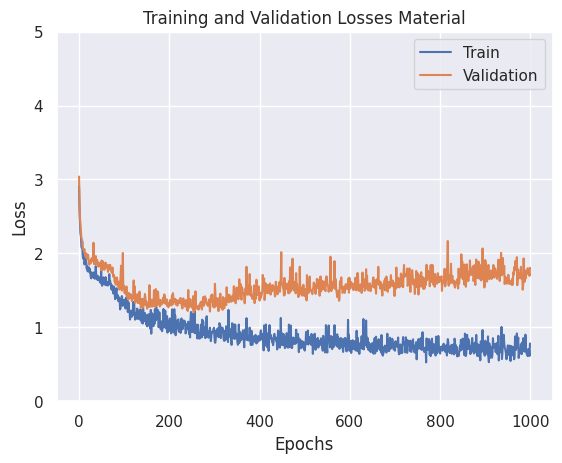

In [126]:
from datetime import datetime
import pytz
def ShowTrainLoss(train_losses,val_losses,save):
    # 日本時間のタイムゾーンを取得
    jst = pytz.timezone('Asia/Tokyo')

    # 現在の日本時間を取得
    now = datetime.now(jst)

    # 時刻を指定された形式の文字列に変換
    time = "_"+now.strftime("%Y%m%d%H%M")

    # 学習曲線の可視化

    title = 'Training and Validation Losses Material'
    plt.plot(train_losses, label='Train')
    plt.plot(val_losses, label='Validation')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.ylim(0,5)
    plt.legend()
    if save == True:
        plt.savefig("data/"+title+time+".pdf")

    plt.show()

ShowTrainLoss(train_losses,val_losses,True)

In [127]:

# dim=1 で行ごとの最大値に対する要素番号を取得（dim=0 は列ごと）
y_label = torch.argmax(y[0], dim=1)
# 予測値から最大となるクラスの番号を取り出した結果
y_label
# 目的変数
t
# 値が一致しているか確認
y_label == t
# int => float 
torch.sum(y_label == t) * 1.0
# 正解率
acc = torch.sum(y_label == t) * 1.0 / len(t)
acc


# 正解率の計算
def calc_acc(data_loader):
    
    with torch.no_grad():
        
        accs = [] # 各バッチごとの結果格納用
        
        for batch in data_loader:
            x, t = batch
            
            # x = torch.unsqueeze(x,1)
            
            x = x.to(device)
            t = t.to(device)
            y = net6(x)
            
            y_label = torch.argmax(y[0], dim=1)
            acc = torch.sum(y_label == t) * 1.0 / len(t)
            accs.append(acc)
            
    # 全体の平均を算出
    avg_acc = torch.tensor(accs).mean()
    print('Accuracy: {:.1f}%'.format(avg_acc * 100))
    
    return avg_acc
      
# 検証データで確認
calc_acc(val_loader)
# テストデータで確認
calc_acc(test_loader)

Accuracy: 48.5%
Accuracy: 45.3%


tensor(0.4529)